In [1]:
import numpy as np
from torch import nn
import torch
import netCDF4
import util.ml_util as ut
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
jan_2020_data, jan_2020_target = ut.load_and_combine_data(2020, 'jan')
jan_2019_data, jan_2019_target = ut.load_and_combine_data(2019, 'jan')
jan_2021_data, jan_2021_target = ut.load_and_combine_data(2021, 'jan')
sc = StandardScaler()
jan_2020_data = sc.fit_transform(jan_2020_data)
jan_2019_data = sc.fit_transform(jan_2019_data)
jan_2021_data = sc.fit_transform(jan_2021_data)
#jan_2019_target +=1
#jan_2019_target = np.log(jan_2019_target)
#jan_2020_target +=1
#jan_2020_target = np.log(jan_2020_target)
#onzero_indices2019 = jan_2019_target[jan_2019_target ==1]
#zero_indices2020 = jan_2020_target[jan_2020_target ==0]


jan_2019_target = np.array([1 if i > 0  else 0 for i in jan_2019_target ])
jan_2020_target = np.array([1 if i > 0  else 0 for i in jan_2020_target ])
jan_2021_target = np.array([1 if i > 0  else 0 for i in jan_2021_target ])

nonzero_data = jan_2019_data[jan_2019_target >0]
print(len(nonzero_data))
nonzero_targets = jan_2019_target[jan_2019_target >0]
for i in range(4):
    jan_2019_data = np.append(jan_2019_data, nonzero_data, axis = 0)
    jan_2019_target = np.append(jan_2019_target, nonzero_targets, axis = 0)

print(np.count_nonzero(jan_2020_target) /len(jan_2020_target))
print(np.count_nonzero(jan_2019_target)/len(jan_2019_target))

1251
0.1244590010527547
0.4389781739069408


In [3]:
N = 14

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        #self.do = nn.Dropout(.3)
        self.fc4 = nn.Linear(64,32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        #x = self.fc5(x)
        return x

class simpleNet(nn.Module):
    def __init__(self, input_shape):
        super(simpleNet, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)
        self.fc2 = nn.Linear(512, input_shape)
        self.fc3 = nn.Linear(input_shape, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

(620, 941)
scatter didnt work
TypeError("'NoneType' object is not subscriptable")
(14, 620, 941)
(583420, 14)
(583420, 1)
[[0.3042867]
 [0.3042867]
 [0.3042867]
 ...
 [0.3042867]
 [0.3042867]
 [0.3042867]]
(620, 941)
[6.798] [0.99985311] 2.6649590163934427


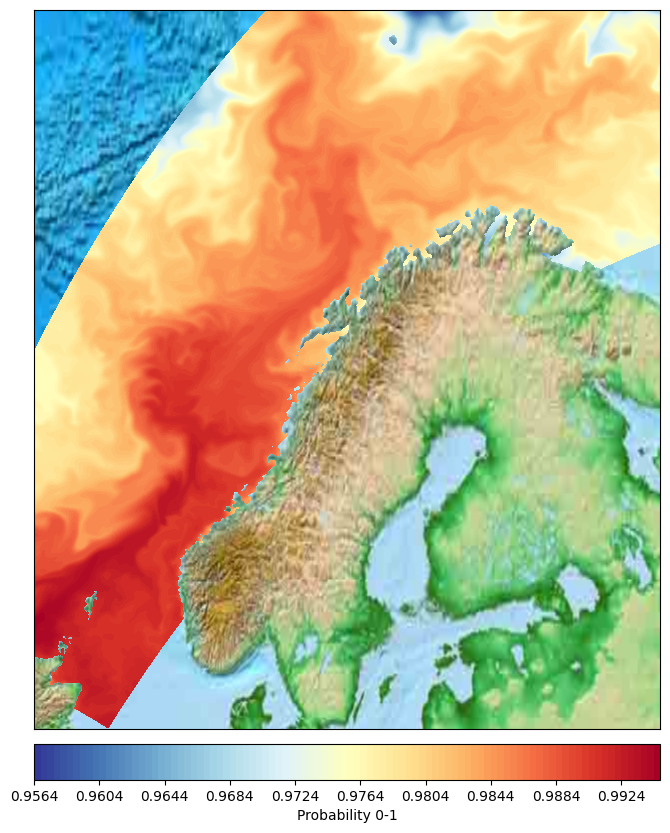

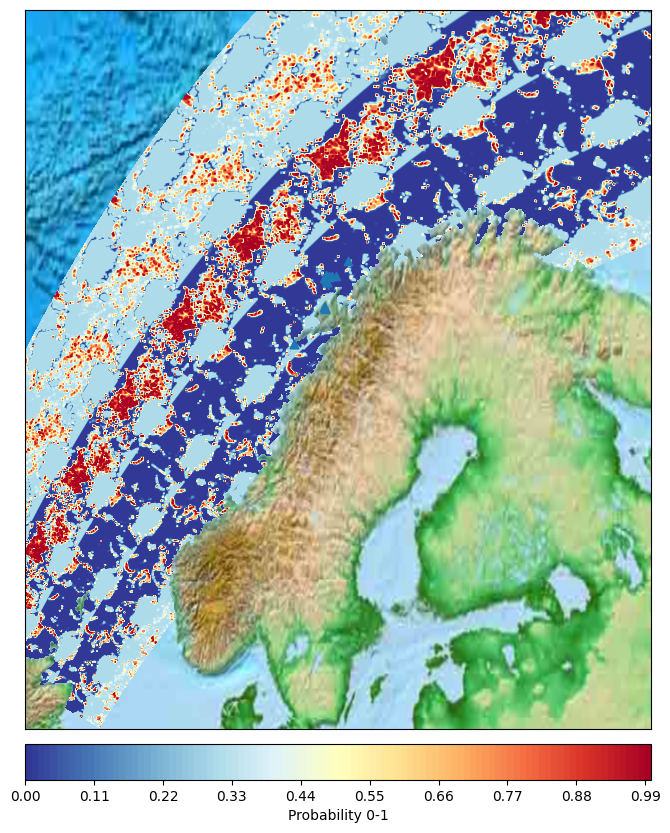

In [6]:
#emperature = netCDF4.Dataset(ut.localize_nc_file('nor4km_data', 2021, 1, 5))['temperature'][12,0,:,:]
#print(temperature.shape)
#ut.print_on_map(temperature)
model = torch.load('pytorch_model')
pred = model(torch.tensor(jan_2021_data, dtype=torch.float32)).detach().numpy()
ut.validate(model,pred, jan_2021_target )

In [12]:
learning_rate = .0005
epochs = 100
model = Net(input_shape=jan_2019_data.shape[1])
#model = simpleNet(input_shape=jan_2019_data.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
#loss_fn = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [9]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
trainset = dataset(jan_2019_data,jan_2019_target)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [13]:
losses = []
accur = []
valid_loss = []
valid_acc = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader):
    
    #calculate output
    output = model(x_train)
    #if j == 0:print(output)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = model(torch.tensor(jan_2019_data,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == jan_2019_target).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%5 == 0:
    losses.append(loss)
    accur.append(acc)
    #print(y_train.shape, output.shape)
    output = model(torch.tensor(jan_2020_data,dtype=torch.float32))
    target = torch.tensor(jan_2020_target,dtype=torch.float32)
    _loss = loss_fn(output, target[:,None])
    _acc = (output.reshape(-1).detach().numpy().round() == jan_2020_target).mean()
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
    print("loss on test set: ", _loss, ' Acc on test set: ', _acc)
    valid_loss.append(_loss)
    valid_acc.append(_acc)

epoch 0	loss : 0.40697479248046875	 accuracy : 0.4389781739069408
loss on test set:  tensor(1.0485, grad_fn=<BinaryCrossEntropyBackward0>)  Acc on test set:  0.1244590010527547
epoch 5	loss : 0.6025885343551636	 accuracy : 0.5860762158747982
loss on test set:  tensor(0.6856, grad_fn=<BinaryCrossEntropyBackward0>)  Acc on test set:  0.3876476780910048
epoch 10	loss : 0.4403674006462097	 accuracy : 0.6183591831005685
loss on test set:  tensor(0.6788, grad_fn=<BinaryCrossEntropyBackward0>)  Acc on test set:  0.47315475494209847
epoch 15	loss : 0.20366784930229187	 accuracy : 0.6340094041687135
loss on test set:  tensor(0.6998, grad_fn=<BinaryCrossEntropyBackward0>)  Acc on test set:  0.5123406246344602
epoch 20	loss : 0.11509090662002563	 accuracy : 0.6505017895992701
loss on test set:  tensor(0.7029, grad_fn=<BinaryCrossEntropyBackward0>)  Acc on test set:  0.5359691191952275
epoch 25	loss : 0.07362409681081772	 accuracy : 0.6643975015790582
loss on test set:  tensor(0.7047, grad_fn=<Bin

In [82]:
#print(jan_2020_data)
#print(model(torch.tensor(jan_2020_data, dtype=torch.float32)))
predicted = model(torch.tensor(jan_2020_data,dtype=torch.float32))
acc = (predicted.reshape(-1).detach().numpy().round() == jan_2020_target).mean()
print(acc)
print(predicted.shape, torch.tensor(jan_2020_target.shape, dtype=torch.float32))
loss = loss_fn(predicted.reshape(1,-1), torch.tensor(jan_2020_target.reshape(1,-1)))
print(loss)

0.8755409989472452
torch.Size([8549, 1]) tensor([8549.])
tensor(14.6905, dtype=torch.float64, grad_fn=<MseLossBackward0>)


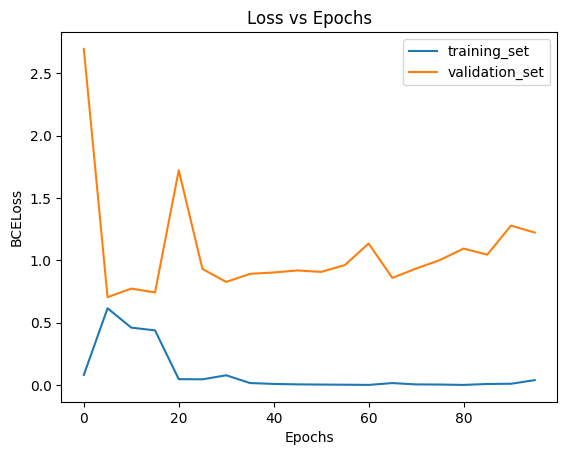

In [7]:
#plotting the loss
losses = [l.data for l in losses]
valid_loss = [l.data for l in valid_loss]
plt.plot([i*5 for i in range(20)], losses)
plt.plot([i*5 for i in range(20)],valid_loss )
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend(['training_set', 'validation_set'])

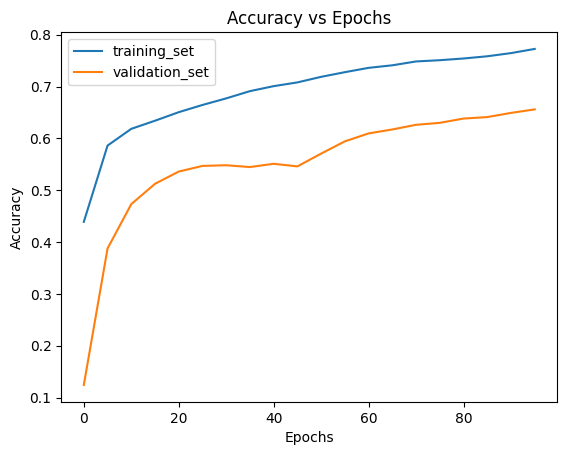

In [14]:
#printing the accuracy
plt.plot( [i*5 for i in range(20)],accur)
plt.plot([i*5 for i in range(20)],valid_acc)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training_set', 'validation_set'])

In [275]:
from sklearn import ensemble, metrics

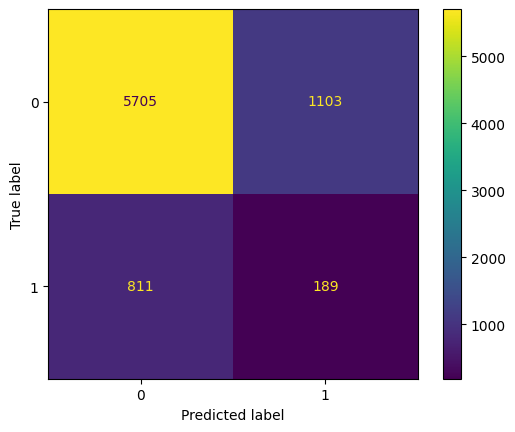

In [371]:
pred = model(torch.tensor(jan_2021_data, dtype=torch.float32)).detach().numpy()
pred = [1 if p > .6 else 0 for p in pred]
metrics.ConfusionMatrixDisplay.from_predictions(jan_2021_target,pred)

[0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725]
[0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725] [0.243, 0.233, 0.22, 0.204, 0.189, 0.181, 0.167, 0.145, 0.047, 0.044]
[0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725] [0.8043478260869565, 0.8121327849588719, 0.8199177438307873, 0.8293184488836662, 0.8379847238542891, 0.8482667450058754, 0.8598707403055229, 0.8742655699177438, 0.9485898942420682, 0.9518213866039953]
[0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725] [0.7324538934426229, 0.7379610655737705, 0.7430840163934426, 0.7492315573770492, 0.7548668032786885, 0.7628073770491803, 0.7711321721311475, 0.7808657786885246, 0.8331198770491803, 0.8355532786885246]


Text(0.5, 0, 'probability cutoff')

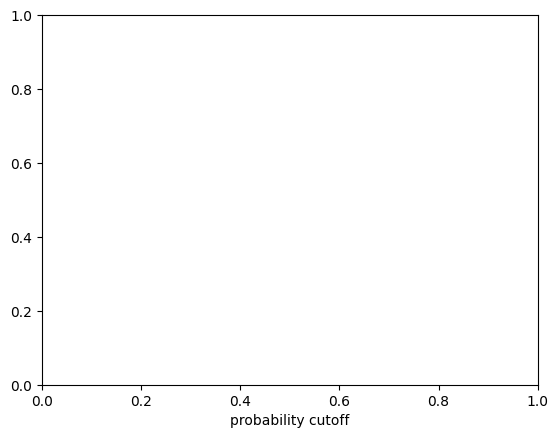

In [381]:
pred = model(torch.tensor(jan_2021_data, dtype=torch.float32)).detach().numpy()
cutoffs = [.5 + .025*i for i in range(10)]
print(cutoffs)
pred =[ [1 if p > c else 0 for p in pred] for c in cutoffs]
acc = []
sens = []
spec = []
all_pos = np.count_nonzero(jan_2021_target)
for p in pred:
    true_pos = 0
    true_neg = 0
    pos = 0
    neg = 0
    acc.append(np.array([p == jan_2021_target]).mean())
    for i in range(len(p)):
        if jan_2021_target[i] == 1:
            if p[i] == 1: 
                true_pos += 1
                pos += 1
            else: neg += 1
        else :
            if p[i] == 1:
                pos += 1
            else:
                neg += 1
                true_neg += 1
   # positives = [_p == 1 for _p in p]
    #negatives = [_p == 0 for _p in p]
    #true_positives = [x == 1 for x in jan_2020_target]
    #true_negatives = [x == 0 for x in jan_2020_target]
    #_sens = np.array([1 if positives[i] == true_positives[i] else 0 for i in range(len(positives))]).mean()
    #_spec = np.array([1 if negatives[i] == true_negatives[i] else 0 for i in range(len(negatives))]).mean()
    sens.append(true_pos/all_pos)
    spec.append(true_neg/ (len(jan_2021_target) - all_pos))
#pred = [np.array([p == jan_2020_target]).mean() for p in pred]
#print(pred)
#print(accuracy)
print([.5 + .025*i for i in range(10)],sens)
print([.5 + .025*i for i in range(10)],spec)
print([.5 + .025*i for i in range(10)],acc)
plt.xlabel("probability cutoff")
#metrics.ConfusionMatrixDisplay.from_predictions(jan_2020_target,pred)

Text(0.5, 0, 'Probability cutoff')

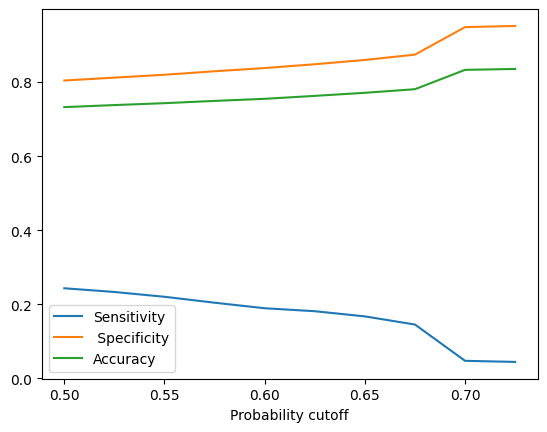

In [382]:
plt.plot([.5 + .025*i for i in range(10)],sens)
plt.plot([.5 + .025*i for i in range(10)],spec)
plt.plot([.5 + .025*i for i in range(10)],acc)
plt.legend(['Sensitivity',' Specificity','Accuracy'])
plt.xlabel("Probability cutoff")

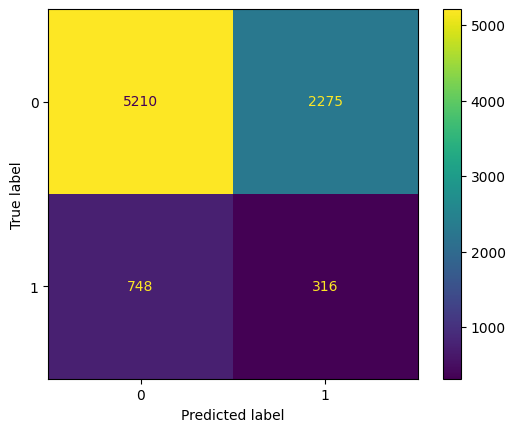

In [280]:
model = ensemble.AdaBoostClassifier(n_estimators=1000, learning_rate = .01)
model.fit(jan_2019_data, jan_2019_target)
r_sq = model.score(jan_2019_data, jan_2019_target)
metrics.ConfusionMatrixDisplay.from_predictions(jan_2020_target,model.predict(jan_2020_data))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
torch.save(model, 'pytorch_model')